# Model stability analysis
In this notebook, we perform stability analysis on the FDA experiment

Optional :  Creation of a temp db

## Imports and setup

In [1]:
# import shutil
# shutil.copy("snorkel_fda_beta.db","_snorkel_fda_temp.db")

In [1]:
import os, sys
import re
from six.moves.cPickle import load
import argparse
from time import time, strftime
from inspect import getmembers, isfunction
from imp import load_source
import numpy as np
from pandas import DataFrame, Series
import json
from subprocess import check_output
import pickle
import pandas as pd
# Note: We import this *before* any import of TF to avoid weird issues
# see- https://github.com/tensorflow/models/issues/523
# Is a bit of a hack but seems harmless as long as SpaCy is installed
import spacy

### Note: No Snorkel imports until after the $SNORKELDB env var is set!
### This is clearly annoying, but also annoying to fix... TODO later in snorkel

expts = list(filter(lambda p : not re.match(r'.*\.pyc?$', p),
    os.listdir('experiments/')))

from utils_mderoche import ArgumentEmulator


args = ArgumentEmulator(verbose=True, exp="fda", disc_model_search_space=1, start_at=7,db_name = "_snorkel_fda_temp")
DEV_SPLIT = 1
TEST_SPLIT = 2 



In [2]:

if args.verbose:
    print(args)

# Get the DB connection string and add to globals
DB_NAME = "snorkel_" + args.exp if args.db_name is None else args.db_name
if not args.postgres:
    DB_NAME += ".db"
DB_TYPE = "postgres" if args.postgres else "sqlite"
DB_ADDR = "localhost:{0}".format(args.db_port) if args.db_port else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

# All Snorkel imports here, after SNORKELDB has been set
from snorkel.annotations import (
    LabelAnnotator, load_label_matrix, load_gold_labels, load_marginals
)
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel, RandomSearch
from snorkel.models.meta import SnorkelBase, snorkel_engine
from snorkel.models import Document, Sentence
from snorkel import SnorkelSession

from utils import *

############################################################################
### [0] Start from clean slate: Clear the DB
############################################################################
if args.start_at == 0:
    if args.verbose > 0:
        print("Reseting DB...")
    if args.postgres:
        raise NotImplementedError("TODO: DB clearing for Postgres.")
    else:
        try:
            _ = check_output(['rm', DB_NAME])
        except:
            pass
    SnorkelBase.metadata.create_all(snorkel_engine)
# Start Snorkel sess
sess = SnorkelSession()

# Only use parallelism > 1 with UDFs if using Postgres
UDF_THREADS = args.n_threads if args.postgres else 1

# Import from parsers.py
preprocess = load_source('preprocess',
    os.path.join('experiments', args.exp, 'preprocess.py'))

# Get candidate subclass from loaded module
C = preprocess.C

# Load the config dictionary
# Load global first, then override any entries with local config file
from config import config
local_config_path = os.path.join('experiments', args.exp, 'config.py')
if os.path.exists(local_config_path):
    local_config = load_source('local_config', local_config_path)
    config = recursive_merge_dicts(config, local_config.config)
if args.verbose > 0:
    print(config)


<utils_mderoche.ArgumentEmulator instance at 0x7f539ac8cb90>
$SNORKELDB = sqlite:///_snorkel_fda_temp.db


/home/matthieu/Documents/Snorkel/snorkel/.snorkelenv.gpu/local/lib/python2.7/site-packages/tensorflow/contrib/tensorboard/plugins/trace/trace.py:22: ImportWarning: Not importing directory '/home/matthieu/Documents/Snorkel/snorkel/parser': missing __init__.py
  import parser


{'gen-init-params': {'lf_propensity': True, 'seed': 123}, 'deps-thresh': 0.01, 'disc-params-range': {'dim': [50, 100], 'dropout': [0.1, 0.25, 0.5], 'lr': [0.0002, 1e-05, 0.0001, 0.0005, 5e-05], 'l2_penalty': [0.01, 0.001, 0.0001], 'rebalance': [0.1, 0.2, 0.05, 0.4], 'l1_penalty': [0.001, 0.0001, 1e-05]}, 'featurizer-init-params': {}, 'disc-eval-batch-size': 32, 'disc-params-default': {'dropout': 0.5, 'batch_size': 64, 'n_epochs': 750, 'beta': 0.9, 'max_sentence_length': 100, 'dim': 50, 'print_freq': 50, 'lr': 0.0002, 'l2_penalty': 0.0001, 'rebalance': 0.1, 'l1_penalty': 0.0002, 'allchecks': False}, 'gen-params-default': {'epochs': 50, 'reg_param': 0.1, 'decay': 0.95}, 'disc-model-class': <class 'snorkel.learning.disc_models.logistic_regression.SparseLogisticRegression'>, 'disc-init-params': {'seed': 123, 'n_threads': 4}, 'featurizer-class': <class 'snorkel.annotations.FeatureAnnotator'>, 'gen-params-range': {'step_size': [0.01, 0.001, 0.0001, 1e-05], 'reg_param': [0.0, 0.01, 0.1, 0.5],

In [3]:
GEN_MODEL_NAME = 'G_final_{0}'.format(args.exp)
L_train, L_dev, L_test = None, None, None
Y_dev, Y_test = None, None
gen_model = None
if args.start_at <= 5:

    # Load L_train if starting here
    if L_train is None or L_dev is None or L_test is None:
        with PrintTimer("[5.0] Loading label matrices..."):
            # Optionally subsample the training set here
            if args.training_docs > 0:
                cids_query = get_training_cids_query(
                    sess,
                    preprocess.CONTEXT_HIERARCHY,
                    C,
                    preprocess.CANDIDATE_CONTEXT,
                    args.training_docs,
                    training_docs_shuffle=args.training_docs_shuffle,
                    verbose=args.verbose,
                    training_splits=args.training_splits
                )
                L_train = load_label_matrix(sess, cids_query=cids_query)
            else:
                L_train = load_label_matrix(sess, split=0)
            L_train = load_label_matrix(sess, split=0)
            assert L_train.nnz > 0
            L_dev = load_label_matrix(sess, split=DEV_SPLIT)
            assert L_dev.nnz > 0
            L_test = load_label_matrix(sess, split=TEST_SPLIT)
            assert L_test.nnz > 0
            if args.verbose > 0:
                print("Using L_train: {0}".format(L_train.__repr__()))
                print("Using L_dev: {0}".format(L_dev.__repr__()))
                print("Using L_test: {0}".format(L_test.__repr__()))

    # Select dependencies to model
    with PrintTimer("[5.1] Selecting dependencies..."):
        if args.deps:
            ds = DependencySelector()
            np.random.seed(args.rand_seed)
            deps = ds.select(L_train, threshold=config['deps-thresh'])
            if args.verbose > 0:
                print("Selected {0} dependencies.".format(len(deps)))
        else:
            deps = ()
            if args.verbose > 0:
                print("Skipping.")

# Run grid search to select best generative model
    with PrintTimer("[5.2] Searching over & training generative models"):
        # Load dev and test labels
        if Y_dev is None:
            Y_dev = load_gold_labels(sess, annotator_name='gold', split=DEV_SPLIT)
            assert Y_dev.nonzero()[0].shape[0] > 0
        if Y_test is None:
            Y_test = load_gold_labels(sess, annotator_name='gold', split=TEST_SPLIT)
            assert Y_test.nonzero()[0].shape[0] > 0

        # Pass in the dependencies via default params
        gen_params_default = config['gen-params-default']
        gen_params_default['deps'] = deps

        # Train generative model with grid search if applicable
        gen_model = train_model(
            GenerativeModel,
            L_train,
            X_dev=L_dev,
            Y_dev=Y_dev,
            search_size=2,#args.gen_model_search_space,
            search_params=config['gen-params-range'],
            rand_seed=args.rand_seed,
            n_threads=args.n_threads,
            verbose=(args.verbose > 0),
            params_default=gen_params_default,
            model_init_params=config['gen-init-params'],
            model_name=GEN_MODEL_NAME,
            save_dir=args.save_dir,
            beta=args.gen_f_beta
        )

        # Save training marginals
        gen_model.save_marginals(sess, L_train, training=True)

        # Score generative model on test set
        print("\n### Gen. model (DP) score on test set:")
        _ = gen_model.error_analysis(sess, L_test, Y_test, display=True)

    if args.one_only:
        sys.exit(0)



We select a model to load: 

In [ ]:
DISC_MODEL_NAME = "SparseLogisticRegression_fullchk_pr3__epoch_439"

In [4]:
############################################################################
### [6] Fit discriminative model
############################################################################

# DISC_MODEL_NAME = 'D_final_{0}'.format(args.exp)

X_train, X_dev, Y_train, disc_model = None, None, None, None
F_train,F_dev,F_test,featurizer = None,None,None,None
if args.start_at <= 6:
    # Load data: candidates, dev labels, training marginals
    with PrintTimer("[6.0] Loading data"):
        # Optionally subsample the training set here
        if args.training_docs > 0:
            cids_query = get_training_cids_query(
                sess,
                preprocess.CONTEXT_HIERARCHY,
                C,
                preprocess.CANDIDATE_CONTEXT,
                args.training_docs,
                training_docs_shuffle=args.training_docs_shuffle,
                verbose=args.verbose,
                training_splits=args.training_splits
            )
            X_train = sess.query(C)\
                .filter(C.id == cids_query.subquery().c.id)\
                .order_by(C.id)\
                .all()
            Y_train = load_marginals(sess, cids_query=cids_query)
        else:
            X_train = sess.query(C).filter(C.split==0).order_by(C.id).all()
            Y_train = load_marginals(sess, split=0)
        assert len(X_train) > 0
        assert Y_train.nonzero()[0].shape[0] > 0

        X_dev = sess.query(C).filter(C.split == DEV_SPLIT).order_by(C.id).all()
        assert len(X_dev) > 0
        if Y_dev is None:
            Y_dev = load_gold_labels(sess,annotator_name='gold',split=DEV_SPLIT)
        assert Y_dev.nonzero()[0].shape[0] > 0
        if args.verbose > 0:
            print("Loaded X_train: {0}".format(len(X_train)))
            print("Loaded Y_train: {0}".format(Y_train.shape))
            print("Loaded X_dev: {0}".format(len(X_dev)))
            print("Loaded Y_dev: {0}".format(Y_dev.shape))

    if not config['disc-model-class'].representation:
        featurizer = config['featurizer-class'](**config.get('featurizer-init-params',dict()))
        with PrintTimer("[6.0.1] Computing Features"):
            if args.recompute_feats:
                F_train = featurizer.apply(split=0)
                F_dev = featurizer.apply_existing(split=DEV_SPLIT)
            else:
                F_train = featurizer.load_matrix(sess,split=0)
                F_dev = featurizer.load_matrix(sess,split=DEV_SPLIT)

    else:
        F_train = X_train
        F_dev = X_dev
    # Run grid search to select best generative model
    with PrintTimer("[6.1] Searching over & training end disc. models"):
        disc_model = train_model(
            config['disc-model-class'],
            F_train,
            Y_train=Y_train,
            X_dev=F_dev,
            Y_dev=Y_dev,
            cardinality=C.cardinality,
            search_size=args.disc_model_search_space,
            search_params=config['disc-params-range'],
            rand_seed=args.rand_seed,
            n_threads=args.n_threads,
            verbose=(args.verbose > 0),
            params_default=config['disc-params-default'],
            model_init_params=config['disc-init-params'],
            model_name=DISC_MODEL_NAME,
            save_dir=args.save_dir,
            eval_batch_size=config['disc-eval-batch-size']
        )

    if args.one_only:
        sys.exit(0)



In [5]:
    if args.start_at <= 7:
        with PrintTimer("[7.0] Loading all data for final evaluation"):
            # TODO: Reload models if needed
            if disc_model is None:
                disc_model = config['disc-model-class'](
                    cardinality=C.cardinality,
                    **config['disc-init-params'])
                disc_model.load(model_name=DISC_MODEL_NAME,
                    save_dir=args.save_dir)

            if gen_model is None:
                gen_model = GenerativeModel(**config['gen-init-params'])
                gen_model.load(model_name=GEN_MODEL_NAME, save_dir=args.save_dir)
            if not disc_model.representation and (featurizer is None):
                featurizer = config['featurizer-class'](**config.get('featurizer-init-params', dict()))


            # TODO: Handle logistic regression as well!
            X_test = sess.query(C).filter(C.split == TEST_SPLIT).order_by(C.id).all()
            if Y_test is None:
                Y_test = load_gold_labels(sess, annotator_name='gold', split=TEST_SPLIT)
                assert Y_test.nonzero()[0].shape[0] > 0
            if L_test is None:
                L_test = load_label_matrix(sess, split=TEST_SPLIT)
                assert L_test.nnz > 0

            if F_test is None:
                if not disc_model.representation:
                    if args.recompute_feats:
                        F_test = featurizer.apply_existing(split=TEST_SPLIT)
                    F_test = featurizer.load_matrix(sess,split=TEST_SPLIT)
                else:
                    F_test  = X_test

            if args.verbose > 0:
                print("Loaded X_test: {0}".format(len(X_test)))
                print("Loaded Y_test: {0}".format(Y_test.shape))
                print("Loaded F_test: representation is {}".format(disc_model.representation))

        if args.custom_error_analysis:
            with PrintTimer("[7.1] Custom error analysis exportation"):
                if X_dev is None:
                    X_dev = sess.query(C).filter(C.split == DEV_SPLIT).order_by(C.id).all()
                if L_dev is None:
                    L_dev = load_label_matrix(sess, split=DEV_SPLIT)
                    assert L_test.nnz > 0
                if Y_dev is None:
                    Y_dev = load_gold_labels(sess, annotator_name='gold', split=DEV_SPLIT)
                if F_dev is None:
                    if not disc_model.representation:
                        F_dev = featurizer.load_matrix(sess,split=DEV_SPLIT)
                    else:
                        F_dev = X_dev


                custom_report_dir = os.path.join(args.reports_dir, strftime("%Y_%m_%d"))
                custom_report_name = '{0}_{1}_custom.pkl'.format(args.exp, strftime("%H_%M_%S"))
                if not os.path.exists(custom_report_dir):
                    os.makedirs(custom_report_dir)
                print "Generative Model"
                custom_report = dict()
                tp, fp, tn, fn = gen_model.error_analysis(sess, L_dev, Y_dev)
                for key,cand_list in zip(['tp', 'fp', 'tn', 'fn'],[tp, fp, tn, fn]):
                    custom_report[key] = [cand.id for cand in cand_list]

                print "Discriminative Model"
                tpd, fpd, tnd, fnd = disc_model.error_analysis(sess, F_dev, Y_dev)
                for key,cand_list in zip(['tpd', 'fpd', 'tnd', 'fnd'],[tpd, fpd, tnd, fnd]):
                    custom_report[key] = [cand.id for cand in cand_list]

                with open(os.path.join(custom_report_dir, custom_report_name), 'wb') as f:
                    pickle.dump(custom_report, f)


        if args.export_pred:
            if X_train is None:
                X_train = sess.query(C).filter(C.split == 0).order_by(C.id).all()

            if F_train is None:
                if not disc_model.representation:
                    if args.recompute_feats:
                        F_train = featurizer.apply_existing(split=0)
                    F_train = featurizer.load_matrix(sess,split=0)
                else:
                    F_train  = X_train

            if X_dev is None:
                X_dev = sess.query(C).filter(C.split == DEV_SPLIT).order_by(C.id).all()

            if F_dev is None:
                if not disc_model.representation:
                    if args.recompute_feats:
                        F_dev = featurizer.apply_existing(split=DEV_SPLIT)
                    F_dev = featurizer.load_matrix(sess, split=DEV_SPLIT)
                else:
                    F_dev = X_dev

            pred_train = disc_model.predictions(F_train,batch_size = int(len(X_train)/400)+1)
            pred_dev = disc_model.predictions(F_dev, batch_size=int(len(X_dev) / 400) + 1)
            pred_test = disc_model.predictions(F_test)

            list_dic_res=  list()
            for cand,pr in zip(X_train+X_dev+X_test,list(pred_train)+list(pred_dev)+list(pred_test)):
                dico_info = dict()
                for i,c in enumerate(cand.get_contexts()):
                    dico_info["cand_"+str(i)+"_start"] = c.char_start
                    dico_info["cand_" + str(i) + "_end"] = c.char_end

                dico_info["sentence_pos"] = cand.get_parent().position
                dico_info["doc_id"] = cand.get_parent().document.name
                dico_info["prediction"] = pr
                list_dic_res.append(dico_info)
            custom_report_dir = os.path.join(args.reports_dir, strftime("%Y_%m_%d"))
            custom_report_name = '{0}_{1}_preds.csv'.format(args.exp, strftime("%H_%M_%S"))
            pd.DataFrame(list_dic_res).to_csv(os.path.join(custom_report_dir, custom_report_name),sep = ";")


        scores = {}
        with PrintTimer("[7.2] Evaluating heuristic baselines"):
            # Test candidate set score - applicable for binary case only
            if C.cardinality == 2:
                cs_test = np.ones(Y_test.shape[0])
                scores['CS'] = score_marginals(cs_test, Y_test)
            else:
                if args.verbose > 0:
                    print("Candidate-set not applicable for categorical tasks.")

            # Test majority vote of LFs on test set
            mv_test = majority_vote_marginals(L_test, cardinality=C.cardinality)
            scores['MV'] = score_marginals(mv_test, Y_test)

        with PrintTimer("[7.3] Evaluating generative model"):
            # Score generative model on test set
            # TODO: Make sure this is the same as scuba.utils score function!!!
            np.random.seed(args.rand_seed)
            scores['Gen'] = score_marginals(gen_model.marginals(L_test), Y_test)

        with PrintTimer("[7.4] Evaluate full DP pipeline (disc. model)"):
            # Score discriminative model trained on generative model predictions
            # TODO: Make sure this is the same as scuba.utils score function!!!
            np.random.seed(args.rand_seed)
            scores['DP'] = score_marginals(disc_model.marginals(F_test,
                    batch_size=config['disc-eval-batch-size']), Y_test)

        if args.ds_tests:
            with PrintTimer("[7.4] Evaluating distant supervision baseline"):
                # Score discriminative model trained on LF majority vote (hard)
                # Load data
                if L_train is None:
                    # Optionally subsample the training set here
                    if args.training_docs > 0:
                        cids_query = get_training_cids_query(
                            sess,
                            preprocess.CONTEXT_HIERARCHY,
                            C,
                            preprocess.CANDIDATE_CONTEXT,
                            args.training_docs,
                            training_docs_shuffle=args.training_docs_shuffle,
                            verbose=args.verbose,
                            training_splits=args.training_splits
                        )
                        L_train = load_label_matrix(sess, cids_query=cids_query)
                    else:
                        L_train = load_label_matrix(sess, split=0)
                    assert L_train.nnz > 0
                if X_train is None:
                    # Optionally subsample the training set here
                    if args.training_docs > 0:
                        cids_query = get_training_cids_query(
                            sess,
                            preprocess.CONTEXT_HIERARCHY,
                            C,
                            preprocess.CANDIDATE_CONTEXT,
                            args.training_docs,
                            training_docs_shuffle=args.training_docs_shuffle,
                            verbose=args.verbose,
                            training_splits=args.training_splits
                        )
                        X_train = sess.query(C)\
                            .filter(C.id == cids_query.subquery().c.id)\
                            .order_by(C.id)\
                            .all()
                    else:
                        X_train = sess.query(C).filter(C.split == 0)\
                        .order_by(C.id).all()
                    assert len(X_train) > 0
                if X_dev is None:
                    X_dev = sess.query(C).filter(C.split == DEV_SPLIT)\
                                .order_by(C.id).all()
                    assert len(X_dev) > 0
                if Y_dev is None:
                    Y_dev = load_gold_labels(sess,annotator_name='gold',split=DEV_SPLIT)
                    assert Y_dev.nonzero()[0].shape[0] > 0

                # Compute soft ([0,1]) majority vote training marginals
                Y_train_mv = majority_vote_marginals(L_train,
                    cardinality=C.cardinality)

                # Train discriminative model with MV training labels
                disc_model = train_model(
                    config['disc-model-class'],
                    X_train,
                    Y_train=Y_train_mv,
                    X_dev=X_dev,
                    Y_dev=Y_dev,
                    cardinality=C.cardinality,
                    search_size=args.disc_model_search_space,
                    search_params=config['disc-params-range'],
                    rand_seed=args.rand_seed,
                    n_threads=args.n_threads,
                    verbose=(args.verbose > 0),
                    params_default=config['disc-params-default'],
                    model_init_params=config['disc-init-params'],
                    model_name=DISC_MODEL_NAME + "_ds",
                    save_dir=args.save_dir,
                    eval_batch_size=config['disc-eval-batch-size']
                )
                np.random.seed(args.rand_seed)
                scores['DS-MV'] = score_marginals(disc_model.marginals(X_test,
                    batch_size=config['disc-eval-batch-size']), Y_test)

        if args.supervised_tests:
            with PrintTimer("[7.5] Evaluating fully-supervised baseline"):
                # Load data
                if X_train is None:
                    # Optionally subsample the training set here
                    if args.training_docs > 0:
                        cids_query = get_training_cids_query(
                            sess,
                            preprocess.CONTEXT_HIERARCHY,
                            C,
                            preprocess.CANDIDATE_CONTEXT,
                            args.training_docs,
                            training_docs_shuffle=args.training_docs_shuffle,
                            verbose=args.verbose,
                            training_splits=args.training_splits
                        )
                        X_train = sess.query(C)\
                            .filter(C.id == cids_query.subquery().c.id)\
                            .order_by(C.id)\
                            .all()
                    else:
                        X_train = sess.query(C).filter(C.split == 0)\
                            .order_by(C.id).all()
                    assert len(X_train) > 0
                if X_dev is None:
                    X_dev = sess.query(C).filter(C.split == DEV_SPLIT)\
                                .order_by(C.id).all()
                    assert len(X_dev) > 0
                if Y_dev is None:
                    Y_dev = load_gold_labels(sess,annotator_name='gold',split=DEV_SPLIT)
                    assert Y_dev.nonzero()[0].shape[0] > 0

                # Load ground-truth training set labels
                # Note we load in {0,1} not {-1,1} format for binary
                # Optionally subsample the training set here
                if args.training_docs > 0:
                    cids_query = get_training_cids_query(
                        sess,
                        preprocess.CONTEXT_HIERARCHY,
                        C,
                        preprocess.CANDIDATE_CONTEXT,
                        args.training_docs,
                        training_docs_shuffle=args.training_docs_shuffle,
                        verbose=args.verbose,
                        training_splits=args.training_splits
                    )
                    Y_train_gt = load_gold_labels(sess, cids_query=cids_query,
                        zero_one=(C.cardinality == 2), load_as_array=True,
                        annotator_name='gold')
                else:
                    Y_train_gt = load_gold_labels(sess, split=0,
                        zero_one=(C.cardinality == 2), load_as_array=True,
                        annotator_name='gold')
                assert Y_train_gt.nonzero()[0].shape[0] > 0

                # If categorical, convert to one-hot
                if C.cardinality > 2:
                    Y_train_gt = labels_to_one_hot(Y_train_gt, C.cardinality)

                # Train discriminative model and score
                disc_model = train_model(
                    config['disc-model-class'],
                    X_train,
                    Y_train=Y_train_gt,
                    X_dev=X_dev,
                    Y_dev=Y_dev,
                    cardinality=C.cardinality,
                    search_size=args.disc_model_search_space,
                    search_params=config['disc-params-range'],
                    rand_seed=args.rand_seed,
                    n_threads=args.n_threads,
                    verbose=(args.verbose > 0),
                    params_default=config['disc-params-default'],
                    model_init_params=config['disc-init-params'],
                    model_name=DISC_MODEL_NAME + "_supervised",
                    save_dir=args.save_dir,
                    eval_batch_size=config['disc-eval-batch-size']
                )
                np.random.seed(args.rand_seed)
                scores['Sup'] = score_marginals(disc_model.marginals(X_test,
                    batch_size=config['disc-eval-batch-size']), Y_test)

        # Print and save final score report
        ks = list(scores.keys())
        if C.cardinality > 2:
            cols = ['Accuracy', 'Coverage']
            d = {
                'Accuracy': Series(data=[scores[k][0] for k in ks], index=ks),
                'Coverage': Series(data=[scores[k][1] for k in ks], index=ks),
            }
        else:
            cols = ['Precision', 'Recall', 'F1 Score']
            d = {
                'Precision' : Series(data=[scores[k][0] for k in ks], index=ks),
                'Recall' : Series(data=[scores[k][1] for k in ks], index=ks),
                'F1 Score' : Series(data=[scores[k][2] for k in ks], index=ks),
                'Coverage' : Series(data=[scores[k][3] for k in ks], index=ks)
            }
        df = DataFrame(data=d, index=ks)
        print(df)

        # Assemble the report, to be saved as a json file
        df_scores = df.to_dict()
        row_str = print_latex_table_row(args.exp, scores,
            cardinality=C.cardinality)
        if args.verbose > 0:
            print(row_str)
        report = {
            'scores': df_scores,
            'row-string': row_str,
            'scuba-commit': git_commit_hash(),
            'snorkel-commit': git_commit_hash(path=os.environ['SNORKELHOME']),
            'args': vars(args)
        }

        # Save to file
        report_dir = os.path.join(args.reports_dir, strftime("%Y_%m_%d"))
        report_name = '{0}_{1}.json'.format(args.exp, strftime("%H_%M_%S"))
        if not os.path.exists(report_dir):
            os.makedirs(report_dir)
        with open(os.path.join(report_dir, report_name), 'wb') as f:
            json.dump(report, f, indent=2)


### [7.0] Loading all data for final evaluation
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk_pr3__epoch_439/SparseLogisticRegression_fullchk_pr3__epoch_439-439
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk_pr3__epoch_439>
[GenerativeModel] Model <G_final_fda> loaded.
Loaded X_test: 1232
Loaded Y_test: (1232, 1)
Loaded F_test: representation is False
### Done in 13.6s.

### [7.2] Evaluating heuristic baselines
### Done in 0.0s.

### [7.3] Evaluating generative model
### Done in 0.3s.

### [7.4] Evaluate full DP pipeline (disc. model)
### Done in 0.1s.

     Coverage  F1 Score  Precision    Recall
CS   1.000000  0.079501   0.041396  1.000000
MV   0.727273  0.338462   0.785714  0.215686
Gen  0.731331  0.338462   0.785714  0.215686
DP   1.000000  0.552632   0.840000  0.411765
fda & 4.1 & 100.0 & 8.0 & 78.6 & 21.6 & 33.8 & 78.6 & 21.6 & 33.8 & - & - & - & 84.0 & 41.2 & 55.3 & - & - & -\\


## Saving the marginals and labels for external analysis

The following cells export the marginals and labels for external analysis

In [12]:
dico_golabs = dict()
dico_labels = dict()
dico_genmarg = dict()

for split in range(3):
    if split>0:
        dico_golabs[split] = load_gold_labels(annotator_name="gold",session=sess,split=split).toarray().ravel()
    dico_labels[split] = load_label_matrix(session=sess,split=split).toarray()
    dico_genmarg[split] = gen_model.marginals(load_label_matrix(session=sess,split=split))

In [13]:
os.mkdir("../ExtraData/Unipolar LFs/fda_regular")

In [14]:
OUTPUT_FOLDER = "../ExtraData/Unipolar LFs/fda_regular/"
for split in range(3):
    if split>0:
        np.save(allow_pickle=False,arr=dico_golabs[split],file=OUTPUT_FOLDER+"golabs_{}.npy".format(split))
    np.save(allow_pickle=False,arr=dico_labels[split],file=OUTPUT_FOLDER+"labels_{}.npy".format(split))
    np.save(allow_pickle=False,arr=dico_genmarg[split],file=OUTPUT_FOLDER+"marg_{}.npy".format(split))
 

### Load feats (for SparseLogisticRegression)

In [6]:
featurizer = config['featurizer-class'](**config.get('featurizer-init-params',dict()))

In [7]:
F_train = featurizer.load_matrix(sess,split=0)

In [8]:
F_dev = featurizer.load_matrix(sess,split=1)
F_test = featurizer.load_matrix(sess,split=2)

In [9]:
F_train,F_dev,F_test

(<65398x373571 sparse matrix of type '<type 'numpy.int64'>'
 	with 2739674 stored elements in Compressed Sparse Row format>,
 <1292x373571 sparse matrix of type '<type 'numpy.int64'>'
 	with 43241 stored elements in Compressed Sparse Row format>,
 <1232x373571 sparse matrix of type '<type 'numpy.int64'>'
 	with 30593 stored elements in Compressed Sparse Row format>)

### Recompute feats (If needed)

In [20]:
F_train = featurizer.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



In [21]:
F_dev = featurizer.apply_existing(split=1)
F_test = featurizer.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%



### (Optional) : defining a validation set

In [17]:
from tqdm import tqdm_notebook

In [18]:
from snorkel.models import GoldLabel,GoldLabelKey,Document

In [10]:
all_training_cands = sess.query(C).filter(C.split==0).order_by(C.id).all()

In [11]:
training_docs = set()
for cand in all_training_cands:
    training_docs.add(cand.get_parent().document.name)

The cell below should be uncommented to generate a validation set and export it

In [12]:
# chosen_val_docs = np.random.choice(list(training_docs),30,replace = False)
# with open("experiments/fda/data/valid/val_docs.txt","w") as f:
#     for doc in chosen_val_docs:
#         f.write(doc+'\n')

The cell below loads an existing val set

In [14]:
chosen_val_docs =list()
with open("experiments/fda/data/valid/val_docs.txt","r") as f:
    for line in f:
        chosen_val_docs.append(line.strip())

In [15]:
len(chosen_val_docs)

30

In [19]:
## Load the associated candidates
val_training_cands = list()
for cand in tqdm_notebook(all_training_cands):
    if cand.get_parent().document.name in chosen_val_docs:
        val_training_cands.append(cand)

HBox(children=(IntProgress(value=0, max=65398), HTML(value=u'')))

In [20]:
len(val_training_cands)

1254

### Adding some labels

In [13]:
from snorkel.viewer import SentenceNgramViewer

In [14]:
len(set (x.get_parent().id for x in val_training_cands))

141

In [15]:
sv = SentenceNgramViewer(annotator_name="validation_set_custom",session=sess,candidates=val_training_cands,height=500)

KeyboardInterrupt: 

RED = SUBSTRACT


BLUE = PRODUCT

In [ ]:
sv

The cell below checks if labels already exist for those candidates and if they are complete

In [21]:
glk = sess.query(GoldLabelKey).filter(GoldLabelKey.name=="validation_set_custom").first()
gls = sess.query(GoldLabel).filter(GoldLabel.key==glk).all()

In [23]:
Y_valid = [a.value for a in sess.query(GoldLabel).filter(GoldLabel.key==glk).order_by(GoldLabel.candidate_id).all()]

In [24]:
gls_sort = sess.query(GoldLabel).filter(GoldLabel.key==glk).order_by(GoldLabel.candidate_id).all()

In [26]:
sorted_dev_cands = sorted(val_training_cands,key = lambda a : a.id)

In [27]:
len(Y_valid),len(sorted_dev_cands)

(1254, 1254)

Exportation of the gold labels if needed

In [22]:
# with open("experiments/fda/data/valid/labels_dev.txt","w") as f:
#     for golab in gls:
#         f.write(str(golab.candidate_id)+'\t'+str(golab.value)+'\t'+golab.candidate.chem1.get_stable_id()+'\t'+golab.candidate.chem2.get_stable_id()+'\n')

In [31]:
_ = disc_model.error_analysis(X_test=sorted_dev_cands,Y_test=Y_valid,display=True,session=sess)

/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

Scores (Un-adjusted)
Pos. class accuracy: 0.271
Neg. class accuracy: 0.989
Precision            0.594
Recall               0.271
F1                   0.373
----------------------------------------
TP: 19 | FP: 13 | TN: 1171 | FN: 51



 Load existing gold labels 

In [26]:
with open("experiments/fda/data/valid/labels_dev.txt","r") as f:
    for line in f:
        list_items = line.split('\t')
        gl = GoldLabel(candidate = sess.query(C).filter(C.id==list_items[0]).first(),key = glk,value = int(list_items[1]))
        sess.add(gl)

In [39]:
sess.commit()

In [21]:
len(sess.query(GoldLabel).all())

5806

### Prepare data for evaluation and load appropriate sets

In [28]:
if X_dev is None:
    X_dev = sess.query(C).filter(C.split == DEV_SPLIT)\
                .order_by(C.id).all()
    assert len(X_dev) > 0
if Y_dev is None:
    Y_dev = load_gold_labels(sess,annotator_name='gold',split=DEV_SPLIT)
    assert Y_dev.nonzero()[0].shape[0] > 0

In [1]:
_=disc_model.error_analysis(sess, X_test, Y_test, display=True)

In [125]:
_=disc_model.error_analysis(sess, X_dev, Y_dev, display=True)

Scores (Un-adjusted)
Pos. class accuracy: 0.433
Neg. class accuracy: 0.984
Precision            0.565
Recall               0.433
F1                   0.491
----------------------------------------
TP: 26 | FP: 20 | TN: 1212 | FN: 34



In [126]:
tp, fp, tn, fn =disc_model.error_analysis(X_test=sorted_dev_cands,Y_test=Y_valid,display=True,session=sess)

Scores (Un-adjusted)
Pos. class accuracy: 0.312
Neg. class accuracy: 0.982
Precision            0.537
Recall               0.312
F1                   0.395
----------------------------------------
TP: 29 | FP: 25 | TN: 1372 | FN: 64



In [105]:
sv_val = SentenceNgramViewer(annotator_name="validation_set_custom",session=sess,candidates=fn,height=500)

<IPython.core.display.Javascript object>

In [2]:
fp

In [107]:
sv_val

SentenceNgramViewer(cids=[[[0], [23], [58]], [[59], [41, 42, 44, 45, 46], [21, 28, 38]], [[51, 52], [25, 29], [26, 27, 31, 32]], [[8, 20], [56, 57, 60], [14]], [[61], [39, 40], [30]], [[24], [2], [9, 13, 47, 48, 49]], [[53, 54], [63], [4, 7]], [[15, 16], [1], [34, 43, 50]], [[55, 62], [3, 6], [17, 18, 19]], [[5], [22], [33]], [[35, 36, 37], [10, 11, 12]]], html=u'<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:500px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="2000"><span class="candidate 0 0-0">Coniferyl aldehyde</span><span class=""> 5-hydroxylation and methylation direct syringyl </span><span class="candidate 0 0-1">lignin</span><span class=""> biosynthesis in angiosperms.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="2001"><span class="">A central question in lignin biosynthesis is how </span><span class="candidate 23 23-0">guaiacyl</span><span class=""> intermediates are hydroxylated and methylated to the </span><span class="candidate 23 23-1">syringyl monolignol</span><span class=""> in angiosperms.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="2010"><span class="">Therefore, in the presence of coniferyl aldehyde, ferulate 5-hydroxylation does not occur, and the </span><span class="candidate 58 58-1">syringyl monolignol</span><span class=""> can be synthesized only from </span><span class="candidate 58 58-0">coniferyl aldehyde</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="2352"><span class="">The results are in agreement with a catabolic route for isoprene involving epoxidation by a monooxygenase, conjugation to glutathione, and oxidation of the </span><span class="candidate 59 59-0">hydroxyl</span><span class=""> group to a </span><span class="candidate 59 59-1">carboxylate</span><span class="">.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="5756"><span class="">The bacterium Zymomonas mobilis is able to produce </span><span class="candidate 42 44 42-1 44-1">sorbitol</span><span class=""> together with </span><span class="candidate 41 45 41-1 45-1">gluconic acid</span><span class=""> from </span><span class="candidate 41 42 41-0 42-0 46 46-1">fructose</span><span class=""> and </span><span class="candidate 44 45 46 44-0 45-0 46-0">glucose</span><span class="">, respectively.</span><

Check the proprtion of positives in the val set (should be around 5 %)

In [109]:
np.mean(np.array(Y_valid)>0)

0.062416107382550337

# Stability study for RNN

In [6]:
disc_model = None

In [7]:
if disc_model is None:
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="D_final_fda",
        save_dir=args.save_dir)

INFO:tensorflow:Restoring parameters from checkpoints/D_final_fda/D_final_fda-0
[reRNN] Loaded model <D_final_fda>


In [118]:
if disc_model is None:
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="D_FINAL_FDA_NEW_SAVE",
        save_dir=args.save_dir)

INFO:tensorflow:Restoring parameters from checkpoints/D_FINAL_FDA_NEW_SAVE/D_FINAL_FDA_NEW_SAVE-0
[reRNN] Loaded model <D_FINAL_FDA_NEW_SAVE>


In [114]:
disc_model

Define placeholders

In [8]:
p_test_list = list()
r_test_list = list()
p_dev_list = list()
r_dev_list = list()
p_val_list = list()
r_val_list = list()
fscore_dev_list = list()
fscore_test_list = list()
fscore_val_list = list()

### Load the models and issue predictions. 
The model must have been trained with the allchecks = True parameter. Change the model name pattern below and select the number of epochs to load.

In [31]:
epochs_to_load = 90

for n_epoch in range(epochs_to_load):
    disc_model = None
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="reRNN_fullchk3_epoch_{}".format(n_epoch),
        save_dir=args.save_dir)
    pt,rt,ft = disc_model.score(X_test, Y_test, batch_size=32,beta=0.8)
    pd,rd,fd = disc_model.score(X_dev, Y_dev, batch_size=32,beta=0.8)
    pv,rv,fv = disc_model.score(sorted_dev_cands, Y_valid, batch_size=32,beta=0.8)
    p_test_list.append(pt) 
    r_test_list.append(rt) 
    p_dev_list.append(pd) 
    r_dev_list.append(rd) 
    fscore_dev_list.append(fd) 
    fscore_test_list.append(ft)
    p_val_list.append(pv)
    r_val_list.append(rv)
    fscore_val_list.append(fv)
    print("P dev:{0:.2f}\tP test:{1:.2f}\tP val:{2:.2f}\tR dev:{3:.2f}\tRtest:{4:.2f}\tRval:{5:.2f}".format(pd,pt,pv,rd,rt,rv) )

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_0/reRNN_fullchk3_epoch_0-0
[reRNN] Loaded model <reRNN_fullchk3_epoch_0>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.60	P test:0.80	P val:0.92	R dev:0.30	Rtest:0.24	Rval:0.16
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_1/reRNN_fullchk3_epoch_1-1
[reRNN] Loaded model <reRNN_fullchk3_epoch_1>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.65	P test:0.61	P val:0.54	R dev:0.43	Rtest:0.33	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_2/reRNN_fullchk3_epoch_2-2
[reRNN] Loaded model <reRNN_fullchk3_epoch_2>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.57	P test:0.50	P val:0.50	R dev:0.38	Rtest:0.31	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_3/reRNN_fullchk3_epoch_3-3
[reRNN] Loaded model <reRNN_fullchk3_epoch_3>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.47	P test:0.68	P val:0.39	R dev:0.45	Rtest:0.45	Rval:0.34
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_4/reRNN_fullchk3_epoch_4-4
[reRNN] Loaded model <reRNN_fullchk3_epoch_4>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.67	P val:0.50	R dev:0.40	Rtest:0.31	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_5/reRNN_fullchk3_epoch_5-5
[reRNN] Loaded model <reRNN_fullchk3_epoch_5>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.53	P test:0.65	P val:0.64	R dev:0.40	Rtest:0.29	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_6/reRNN_fullchk3_epoch_6-6
[reRNN] Loaded model <reRNN_fullchk3_epoch_6>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.54	P val:0.44	R dev:0.43	Rtest:0.29	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_7/reRNN_fullchk3_epoch_7-7
[reRNN] Loaded model <reRNN_fullchk3_epoch_7>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.48	P val:0.53	R dev:0.38	Rtest:0.31	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_8/reRNN_fullchk3_epoch_8-8
[reRNN] Loaded model <reRNN_fullchk3_epoch_8>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.58	P test:0.73	P val:0.68	R dev:0.37	Rtest:0.31	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_9/reRNN_fullchk3_epoch_9-9
[reRNN] Loaded model <reRNN_fullchk3_epoch_9>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.58	P test:0.62	P val:0.51	R dev:0.48	Rtest:0.31	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_10/reRNN_fullchk3_epoch_10-10
[reRNN] Loaded model <reRNN_fullchk3_epoch_10>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.56	P test:0.68	P val:0.53	R dev:0.48	Rtest:0.37	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_11/reRNN_fullchk3_epoch_11-11
[reRNN] Loaded model <reRNN_fullchk3_epoch_11>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.54	P test:0.55	P val:0.45	R dev:0.50	Rtest:0.31	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_12/reRNN_fullchk3_epoch_12-12
[reRNN] Loaded model <reRNN_fullchk3_epoch_12>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.53	P test:0.68	P val:0.50	R dev:0.52	Rtest:0.37	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_13/reRNN_fullchk3_epoch_13-13
[reRNN] Loaded model <reRNN_fullchk3_epoch_13>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.60	P test:0.61	P val:0.64	R dev:0.52	Rtest:0.39	Rval:0.30
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_14/reRNN_fullchk3_epoch_14-14
[reRNN] Loaded model <reRNN_fullchk3_epoch_14>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.65	P val:0.74	R dev:0.43	Rtest:0.25	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_15/reRNN_fullchk3_epoch_15-15
[reRNN] Loaded model <reRNN_fullchk3_epoch_15>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.41	P val:0.58	R dev:0.48	Rtest:0.37	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_16/reRNN_fullchk3_epoch_16-16
[reRNN] Loaded model <reRNN_fullchk3_epoch_16>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.64	P val:0.55	R dev:0.47	Rtest:0.35	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_17/reRNN_fullchk3_epoch_17-17
[reRNN] Loaded model <reRNN_fullchk3_epoch_17>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.59	P val:0.43	R dev:0.50	Rtest:0.37	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_18/reRNN_fullchk3_epoch_18-18
[reRNN] Loaded model <reRNN_fullchk3_epoch_18>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.62	P val:0.43	R dev:0.52	Rtest:0.39	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_19/reRNN_fullchk3_epoch_19-19
[reRNN] Loaded model <reRNN_fullchk3_epoch_19>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.54	P val:0.42	R dev:0.50	Rtest:0.37	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_20/reRNN_fullchk3_epoch_20-20
[reRNN] Loaded model <reRNN_fullchk3_epoch_20>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.51	P test:0.50	P val:0.43	R dev:0.55	Rtest:0.41	Rval:0.29
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_21/reRNN_fullchk3_epoch_21-21
[reRNN] Loaded model <reRNN_fullchk3_epoch_21>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.49	P val:0.36	R dev:0.58	Rtest:0.59	Rval:0.29
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_22/reRNN_fullchk3_epoch_22-22
[reRNN] Loaded model <reRNN_fullchk3_epoch_22>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.42	P test:0.51	P val:0.39	R dev:0.52	Rtest:0.51	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_23/reRNN_fullchk3_epoch_23-23
[reRNN] Loaded model <reRNN_fullchk3_epoch_23>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.66	P val:0.45	R dev:0.45	Rtest:0.37	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_24/reRNN_fullchk3_epoch_24-24
[reRNN] Loaded model <reRNN_fullchk3_epoch_24>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.67	P val:0.45	R dev:0.52	Rtest:0.43	Rval:0.30
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_25/reRNN_fullchk3_epoch_25-25
[reRNN] Loaded model <reRNN_fullchk3_epoch_25>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.61	P val:0.48	R dev:0.45	Rtest:0.39	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_26/reRNN_fullchk3_epoch_26-26
[reRNN] Loaded model <reRNN_fullchk3_epoch_26>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.53	P test:0.57	P val:0.42	R dev:0.58	Rtest:0.49	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_27/reRNN_fullchk3_epoch_27-27
[reRNN] Loaded model <reRNN_fullchk3_epoch_27>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.46	P test:0.52	P val:0.40	R dev:0.53	Rtest:0.43	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_28/reRNN_fullchk3_epoch_28-28
[reRNN] Loaded model <reRNN_fullchk3_epoch_28>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.45	P test:0.49	P val:0.35	R dev:0.55	Rtest:0.53	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_29/reRNN_fullchk3_epoch_29-29
[reRNN] Loaded model <reRNN_fullchk3_epoch_29>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.44	P test:0.46	P val:0.35	R dev:0.57	Rtest:0.41	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_30/reRNN_fullchk3_epoch_30-30
[reRNN] Loaded model <reRNN_fullchk3_epoch_30>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.43	P test:0.56	P val:0.38	R dev:0.53	Rtest:0.45	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_31/reRNN_fullchk3_epoch_31-31
[reRNN] Loaded model <reRNN_fullchk3_epoch_31>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.58	P val:0.39	R dev:0.50	Rtest:0.43	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_32/reRNN_fullchk3_epoch_32-32
[reRNN] Loaded model <reRNN_fullchk3_epoch_32>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.40	P test:0.60	P val:0.39	R dev:0.50	Rtest:0.49	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_33/reRNN_fullchk3_epoch_33-33
[reRNN] Loaded model <reRNN_fullchk3_epoch_33>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.46	P test:0.69	P val:0.47	R dev:0.52	Rtest:0.49	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_34/reRNN_fullchk3_epoch_34-34
[reRNN] Loaded model <reRNN_fullchk3_epoch_34>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.45	P test:0.66	P val:0.37	R dev:0.52	Rtest:0.53	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_35/reRNN_fullchk3_epoch_35-35
[reRNN] Loaded model <reRNN_fullchk3_epoch_35>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.44	P test:0.62	P val:0.33	R dev:0.50	Rtest:0.49	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_36/reRNN_fullchk3_epoch_36-36
[reRNN] Loaded model <reRNN_fullchk3_epoch_36>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.46	P test:0.58	P val:0.31	R dev:0.53	Rtest:0.43	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_37/reRNN_fullchk3_epoch_37-37
[reRNN] Loaded model <reRNN_fullchk3_epoch_37>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.69	P val:0.38	R dev:0.48	Rtest:0.43	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_38/reRNN_fullchk3_epoch_38-38
[reRNN] Loaded model <reRNN_fullchk3_epoch_38>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.62	P val:0.39	R dev:0.50	Rtest:0.45	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_39/reRNN_fullchk3_epoch_39-39
[reRNN] Loaded model <reRNN_fullchk3_epoch_39>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.56	P test:0.89	P val:0.45	R dev:0.37	Rtest:0.33	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_40/reRNN_fullchk3_epoch_40-40
[reRNN] Loaded model <reRNN_fullchk3_epoch_40>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.70	P val:0.36	R dev:0.50	Rtest:0.51	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_41/reRNN_fullchk3_epoch_41-41
[reRNN] Loaded model <reRNN_fullchk3_epoch_41>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.55	P val:0.35	R dev:0.50	Rtest:0.41	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_42/reRNN_fullchk3_epoch_42-42
[reRNN] Loaded model <reRNN_fullchk3_epoch_42>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.47	P test:0.64	P val:0.42	R dev:0.45	Rtest:0.41	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_43/reRNN_fullchk3_epoch_43-43
[reRNN] Loaded model <reRNN_fullchk3_epoch_43>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.51	P test:0.58	P val:0.40	R dev:0.43	Rtest:0.43	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_44/reRNN_fullchk3_epoch_44-44
[reRNN] Loaded model <reRNN_fullchk3_epoch_44>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.58	P test:0.66	P val:0.50	R dev:0.43	Rtest:0.37	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_45/reRNN_fullchk3_epoch_45-45
[reRNN] Loaded model <reRNN_fullchk3_epoch_45>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.73	P val:0.46	R dev:0.38	Rtest:0.37	Rval:0.17
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_46/reRNN_fullchk3_epoch_46-46
[reRNN] Loaded model <reRNN_fullchk3_epoch_46>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.59	P test:0.62	P val:0.46	R dev:0.37	Rtest:0.41	Rval:0.19
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_47/reRNN_fullchk3_epoch_47-47
[reRNN] Loaded model <reRNN_fullchk3_epoch_47>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.42	P test:0.57	P val:0.44	R dev:0.47	Rtest:0.53	Rval:0.29
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_48/reRNN_fullchk3_epoch_48-48
[reRNN] Loaded model <reRNN_fullchk3_epoch_48>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.45	P test:0.64	P val:0.43	R dev:0.43	Rtest:0.41	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_49/reRNN_fullchk3_epoch_49-49
[reRNN] Loaded model <reRNN_fullchk3_epoch_49>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.65	P val:0.49	R dev:0.45	Rtest:0.29	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_50/reRNN_fullchk3_epoch_50-50
[reRNN] Loaded model <reRNN_fullchk3_epoch_50>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.53	P test:0.65	P val:0.56	R dev:0.47	Rtest:0.33	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_51/reRNN_fullchk3_epoch_51-51
[reRNN] Loaded model <reRNN_fullchk3_epoch_51>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.51	P val:0.45	R dev:0.45	Rtest:0.39	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_52/reRNN_fullchk3_epoch_52-52
[reRNN] Loaded model <reRNN_fullchk3_epoch_52>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.44	P test:0.53	P val:0.38	R dev:0.45	Rtest:0.39	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_53/reRNN_fullchk3_epoch_53-53
[reRNN] Loaded model <reRNN_fullchk3_epoch_53>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.56	P val:0.44	R dev:0.45	Rtest:0.35	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_54/reRNN_fullchk3_epoch_54-54
[reRNN] Loaded model <reRNN_fullchk3_epoch_54>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.60	P val:0.47	R dev:0.37	Rtest:0.35	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_55/reRNN_fullchk3_epoch_55-55
[reRNN] Loaded model <reRNN_fullchk3_epoch_55>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.42	P val:0.36	R dev:0.50	Rtest:0.51	Rval:0.29
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_56/reRNN_fullchk3_epoch_56-56
[reRNN] Loaded model <reRNN_fullchk3_epoch_56>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.56	P test:0.47	P val:0.49	R dev:0.48	Rtest:0.37	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_57/reRNN_fullchk3_epoch_57-57
[reRNN] Loaded model <reRNN_fullchk3_epoch_57>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.61	P test:0.61	P val:0.54	R dev:0.47	Rtest:0.39	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_58/reRNN_fullchk3_epoch_58-58
[reRNN] Loaded model <reRNN_fullchk3_epoch_58>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.57	P test:0.59	P val:0.52	R dev:0.45	Rtest:0.39	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_59/reRNN_fullchk3_epoch_59-59
[reRNN] Loaded model <reRNN_fullchk3_epoch_59>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.54	P test:0.50	P val:0.47	R dev:0.43	Rtest:0.37	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_60/reRNN_fullchk3_epoch_60-60
[reRNN] Loaded model <reRNN_fullchk3_epoch_60>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.44	P test:0.61	P val:0.50	R dev:0.43	Rtest:0.33	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_61/reRNN_fullchk3_epoch_61-61
[reRNN] Loaded model <reRNN_fullchk3_epoch_61>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.45	P test:0.57	P val:0.42	R dev:0.50	Rtest:0.51	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_62/reRNN_fullchk3_epoch_62-62
[reRNN] Loaded model <reRNN_fullchk3_epoch_62>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.53	P test:0.71	P val:0.41	R dev:0.52	Rtest:0.53	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_63/reRNN_fullchk3_epoch_63-63
[reRNN] Loaded model <reRNN_fullchk3_epoch_63>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.58	P test:0.67	P val:0.47	R dev:0.50	Rtest:0.39	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_64/reRNN_fullchk3_epoch_64-64
[reRNN] Loaded model <reRNN_fullchk3_epoch_64>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.48	P val:0.41	R dev:0.57	Rtest:0.49	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_65/reRNN_fullchk3_epoch_65-65
[reRNN] Loaded model <reRNN_fullchk3_epoch_65>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.54	P test:0.77	P val:0.41	R dev:0.55	Rtest:0.39	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_66/reRNN_fullchk3_epoch_66-66
[reRNN] Loaded model <reRNN_fullchk3_epoch_66>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.67	P val:0.33	R dev:0.55	Rtest:0.43	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_67/reRNN_fullchk3_epoch_67-67
[reRNN] Loaded model <reRNN_fullchk3_epoch_67>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.51	P test:0.56	P val:0.40	R dev:0.48	Rtest:0.37	Rval:0.24
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_68/reRNN_fullchk3_epoch_68-68
[reRNN] Loaded model <reRNN_fullchk3_epoch_68>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.40	P val:0.41	R dev:0.50	Rtest:0.43	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_69/reRNN_fullchk3_epoch_69-69
[reRNN] Loaded model <reRNN_fullchk3_epoch_69>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.72	P val:0.62	R dev:0.38	Rtest:0.35	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_70/reRNN_fullchk3_epoch_70-70
[reRNN] Loaded model <reRNN_fullchk3_epoch_70>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.45	P test:0.31	P val:0.37	R dev:0.48	Rtest:0.45	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_71/reRNN_fullchk3_epoch_71-71
[reRNN] Loaded model <reRNN_fullchk3_epoch_71>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.43	P test:0.40	P val:0.41	R dev:0.38	Rtest:0.41	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_72/reRNN_fullchk3_epoch_72-72
[reRNN] Loaded model <reRNN_fullchk3_epoch_72>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.47	P test:0.40	P val:0.38	R dev:0.45	Rtest:0.37	Rval:0.16
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_73/reRNN_fullchk3_epoch_73-73
[reRNN] Loaded model <reRNN_fullchk3_epoch_73>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.47	P test:0.27	P val:0.42	R dev:0.58	Rtest:0.43	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_74/reRNN_fullchk3_epoch_74-74
[reRNN] Loaded model <reRNN_fullchk3_epoch_74>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.43	P test:0.25	P val:0.33	R dev:0.52	Rtest:0.41	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_75/reRNN_fullchk3_epoch_75-75
[reRNN] Loaded model <reRNN_fullchk3_epoch_75>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.46	P val:0.36	R dev:0.47	Rtest:0.41	Rval:0.19
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_76/reRNN_fullchk3_epoch_76-76
[reRNN] Loaded model <reRNN_fullchk3_epoch_76>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.50	P test:0.44	P val:0.31	R dev:0.53	Rtest:0.45	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_77/reRNN_fullchk3_epoch_77-77
[reRNN] Loaded model <reRNN_fullchk3_epoch_77>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.45	P val:0.33	R dev:0.52	Rtest:0.49	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_78/reRNN_fullchk3_epoch_78-78
[reRNN] Loaded model <reRNN_fullchk3_epoch_78>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.44	P val:0.33	R dev:0.48	Rtest:0.37	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_79/reRNN_fullchk3_epoch_79-79
[reRNN] Loaded model <reRNN_fullchk3_epoch_79>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.50	P val:0.39	R dev:0.47	Rtest:0.37	Rval:0.20
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_80/reRNN_fullchk3_epoch_80-80
[reRNN] Loaded model <reRNN_fullchk3_epoch_80>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.48	P test:0.41	P val:0.44	R dev:0.43	Rtest:0.41	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_81/reRNN_fullchk3_epoch_81-81
[reRNN] Loaded model <reRNN_fullchk3_epoch_81>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.43	P test:0.49	P val:0.44	R dev:0.47	Rtest:0.45	Rval:0.27
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_82/reRNN_fullchk3_epoch_82-82
[reRNN] Loaded model <reRNN_fullchk3_epoch_82>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.49	P test:0.48	P val:0.42	R dev:0.52	Rtest:0.43	Rval:0.26
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_83/reRNN_fullchk3_epoch_83-83
[reRNN] Loaded model <reRNN_fullchk3_epoch_83>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.41	P test:0.51	P val:0.42	R dev:0.42	Rtest:0.39	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_84/reRNN_fullchk3_epoch_84-84
[reRNN] Loaded model <reRNN_fullchk3_epoch_84>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.46	P test:0.41	P val:0.41	R dev:0.50	Rtest:0.37	Rval:0.21
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_85/reRNN_fullchk3_epoch_85-85
[reRNN] Loaded model <reRNN_fullchk3_epoch_85>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.52	P test:0.40	P val:0.50	R dev:0.47	Rtest:0.35	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_86/reRNN_fullchk3_epoch_86-86
[reRNN] Loaded model <reRNN_fullchk3_epoch_86>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.55	P test:0.49	P val:0.64	R dev:0.43	Rtest:0.33	Rval:0.23
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_87/reRNN_fullchk3_epoch_87-87
[reRNN] Loaded model <reRNN_fullchk3_epoch_87>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.54	P test:0.43	P val:0.46	R dev:0.45	Rtest:0.35	Rval:0.19
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_88/reRNN_fullchk3_epoch_88-88
[reRNN] Loaded model <reRNN_fullchk3_epoch_88>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.62	P test:0.54	P val:0.42	R dev:0.43	Rtest:0.41	Rval:0.19
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk3_epoch_89/reRNN_fullchk3_epoch_89-89
[reRNN] Loaded model <reRNN_fullchk3_epoch_89>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 16 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

P dev:0.54	P test:0.44	P val:0.39	R dev:0.47	Rtest:0.43	Rval:0.21


Plot the precision

In [33]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


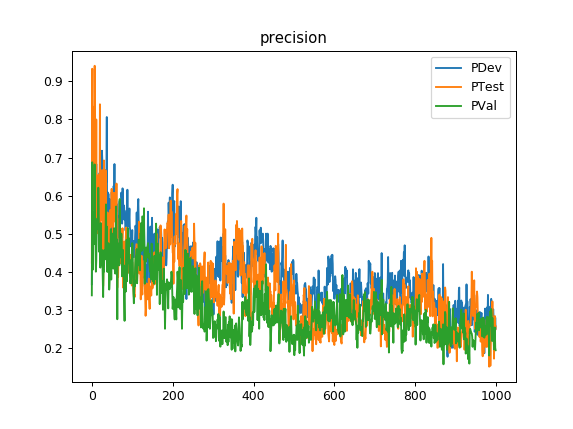

Text(0.5,1,u'precision')

In [27]:
plt.plot(p_dev_list,label = "PDev")
plt.plot(p_test_list,label = "PTest")
plt.plot(p_val_list,label = "PVal")
plt.legend()
plt.title("precision")

<IPython.core.display.Javascript object>


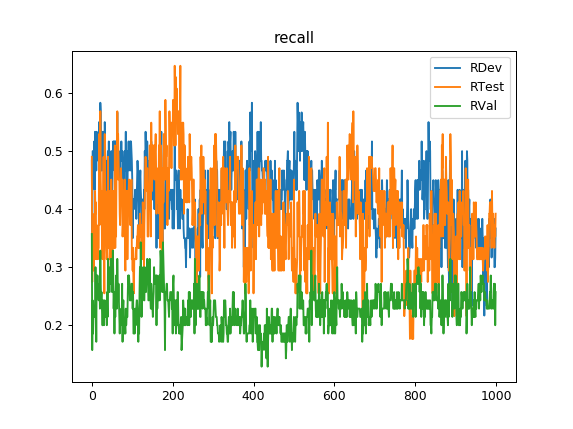

Text(0.5,1,u'recall')

In [28]:
plt.plot(r_dev_list,label = "RDev")
plt.plot(r_test_list,label = "RTest")
plt.plot(r_val_list,label = "RVal")
plt.legend()
plt.title("recall")

#### Compute and plot the F1 score

In [29]:
f1_list_dev = list()
f1_list_test = list()
f1_list_val = list()
for p,r in zip(p_dev_list,r_dev_list):
    f1_list_dev.append(2*p*r/(p+r))
for p,r in zip(p_test_list,r_test_list):
    f1_list_test.append(2*p*r/(p+r))
for p,r in zip(p_val_list,r_val_list):
    f1_list_val.append(2*p*r/(p+r))

<IPython.core.display.Javascript object>


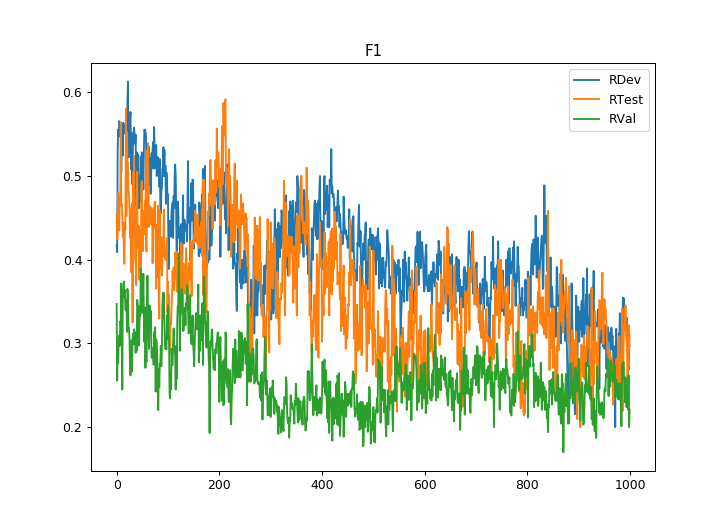

Text(0.5,1,u'F1')

In [30]:
plt.plot(f1_list_dev,label = "RDev")
plt.plot(f1_list_test,label = "RTest")
plt.plot(f1_list_val,label = "RVal")
plt.legend()
plt.title("F1")

(Optional) If the loss is available (output of the training captured in a file, load and plot it)

In [31]:
lst_loss = list()
with open("../Notes/training_bigrnn.txt","r") as f:
    for line in f:
        if "loss" in line:
            lss = float(line.split("loss=")[-1].split()[0].strip())
            lst_loss.append(lss)

<IPython.core.display.Javascript object>


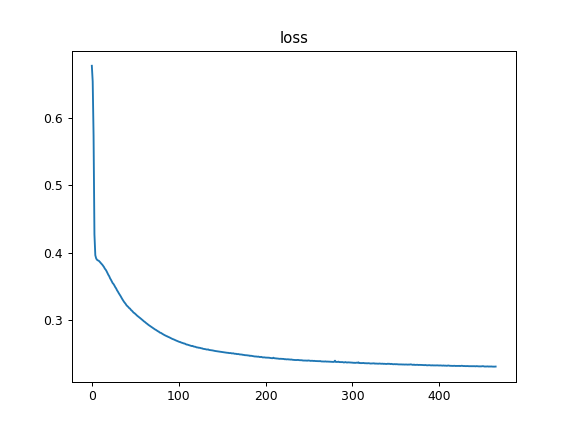

Text(0.5,1,u'loss')

In [34]:
plt.plot(lst_loss)
plt.title("loss")

## Stability plots

This section defines **stability plots**.

The purpose of these plots is to visualize the evolutions of the errors made by the network along the training and see if the errors can be clustered by document, and more generally if we have the same kind of errors at the beginning and end of the training or if they are different

##### Load models and issue predictions

In [35]:
dict_doc_ids = dict()

In [36]:
dic_info_lst = list()
for n_epoch in range(45):
    disc_model = None
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="reRNN_fullchk_epoch_{}".format(n_epoch),
        save_dir=args.save_dir)
    _, fpv, _, fnv =disc_model.error_analysis(X_test=sorted_dev_cands,Y_test=Y_valid,display=False,session=sess)
    _, fpd, _, fnd =disc_model.error_analysis(X_test=X_dev,Y_test=Y_dev,display=False,session=sess)
    _, fpt, _, fnt =disc_model.error_analysis(X_test=X_test,Y_test=Y_test,display=False,session=sess)
    for x in list(fpv)+list(fnv)+list(fpd)+list(fnd)+list(fpt)+list(fnt):
        dict_doc_ids[x.id] = x[0].get_parent().document.name
    dic_info_lst.append(dict(epoch = n_epoch, fpv_id = [c.id for c in fpv], fnv_id = [c.id for c in fnv], fpt_id = [c.id for c in fpt], fnt_id = [c.id for c in fnt], fpd_id = [c.id for c in fpd], fnd_id = [c.id for c in fnd]))

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_0/reRNN_fullchk_epoch_0-0
[reRNN] Loaded model <reRNN_fullchk_epoch_0>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_1/reRNN_fullchk_epoch_1-1
[reRNN] Loaded model <reRNN_fullchk_epoch_1>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_2/reRNN_fullchk_epoch_2-2
[reRNN] Loaded model <reRNN_fullchk_epoch_2>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_3/reRNN_fullchk_epoch_3-3
[reRNN] Loaded model <reRNN_fullchk_epoch_3>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_4/reRNN_fullchk_epoch_4-4
[reRNN] Loaded model <reRNN_fullchk_epoch_4>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_5/reRNN_fullchk_epoch_5-5
[reRNN] Loaded model <reRNN_fullchk_epoch_5>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_6/reRNN_fullchk_epoch_6-6
[reRNN] Loaded model <reRNN_fullchk_epoch_6>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_7/reRNN_fullchk_epoch_7-7
[reRNN] Loaded model <reRNN_fullchk_epoch_7>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_8/reRNN_fullchk_epoch_8-8
[reRNN] Loaded model <reRNN_fullchk_epoch_8>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_9/reRNN_fullchk_epoch_9-9
[reRNN] Loaded model <reRNN_fullchk_epoch_9>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_10/reRNN_fullchk_epoch_10-10
[reRNN] Loaded model <reRNN_fullchk_epoch_10>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_11/reRNN_fullchk_epoch_11-11
[reRNN] Loaded model <reRNN_fullchk_epoch_11>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_12/reRNN_fullchk_epoch_12-12
[reRNN] Loaded model <reRNN_fullchk_epoch_12>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_13/reRNN_fullchk_epoch_13-13
[reRNN] Loaded model <reRNN_fullchk_epoch_13>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_14/reRNN_fullchk_epoch_14-14
[reRNN] Loaded model <reRNN_fullchk_epoch_14>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_15/reRNN_fullchk_epoch_15-15
[reRNN] Loaded model <reRNN_fullchk_epoch_15>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_16/reRNN_fullchk_epoch_16-16
[reRNN] Loaded model <reRNN_fullchk_epoch_16>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_17/reRNN_fullchk_epoch_17-17
[reRNN] Loaded model <reRNN_fullchk_epoch_17>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_18/reRNN_fullchk_epoch_18-18
[reRNN] Loaded model <reRNN_fullchk_epoch_18>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_19/reRNN_fullchk_epoch_19-19
[reRNN] Loaded model <reRNN_fullchk_epoch_19>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_20/reRNN_fullchk_epoch_20-20
[reRNN] Loaded model <reRNN_fullchk_epoch_20>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_21/reRNN_fullchk_epoch_21-21
[reRNN] Loaded model <reRNN_fullchk_epoch_21>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_22/reRNN_fullchk_epoch_22-22
[reRNN] Loaded model <reRNN_fullchk_epoch_22>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_23/reRNN_fullchk_epoch_23-23
[reRNN] Loaded model <reRNN_fullchk_epoch_23>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_24/reRNN_fullchk_epoch_24-24
[reRNN] Loaded model <reRNN_fullchk_epoch_24>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_25/reRNN_fullchk_epoch_25-25
[reRNN] Loaded model <reRNN_fullchk_epoch_25>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_26/reRNN_fullchk_epoch_26-26
[reRNN] Loaded model <reRNN_fullchk_epoch_26>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_27/reRNN_fullchk_epoch_27-27
[reRNN] Loaded model <reRNN_fullchk_epoch_27>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_28/reRNN_fullchk_epoch_28-28
[reRNN] Loaded model <reRNN_fullchk_epoch_28>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_29/reRNN_fullchk_epoch_29-29
[reRNN] Loaded model <reRNN_fullchk_epoch_29>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_30/reRNN_fullchk_epoch_30-30
[reRNN] Loaded model <reRNN_fullchk_epoch_30>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_31/reRNN_fullchk_epoch_31-31
[reRNN] Loaded model <reRNN_fullchk_epoch_31>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_32/reRNN_fullchk_epoch_32-32
[reRNN] Loaded model <reRNN_fullchk_epoch_32>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_33/reRNN_fullchk_epoch_33-33
[reRNN] Loaded model <reRNN_fullchk_epoch_33>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_34/reRNN_fullchk_epoch_34-34
[reRNN] Loaded model <reRNN_fullchk_epoch_34>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_35/reRNN_fullchk_epoch_35-35
[reRNN] Loaded model <reRNN_fullchk_epoch_35>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_36/reRNN_fullchk_epoch_36-36
[reRNN] Loaded model <reRNN_fullchk_epoch_36>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_37/reRNN_fullchk_epoch_37-37
[reRNN] Loaded model <reRNN_fullchk_epoch_37>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_38/reRNN_fullchk_epoch_38-38
[reRNN] Loaded model <reRNN_fullchk_epoch_38>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_39/reRNN_fullchk_epoch_39-39
[reRNN] Loaded model <reRNN_fullchk_epoch_39>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_40/reRNN_fullchk_epoch_40-40
[reRNN] Loaded model <reRNN_fullchk_epoch_40>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_41/reRNN_fullchk_epoch_41-41
[reRNN] Loaded model <reRNN_fullchk_epoch_41>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_42/reRNN_fullchk_epoch_42-42
[reRNN] Loaded model <reRNN_fullchk_epoch_42>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_43/reRNN_fullchk_epoch_43-43
[reRNN] Loaded model <reRNN_fullchk_epoch_43>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk_epoch_44/reRNN_fullchk_epoch_44-44
[reRNN] Loaded model <reRNN_fullchk_epoch_44>


/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 78 has argument past max length for model:	[arg ends at index 123; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 79 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 80 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 81 has argument past max length for model:	[arg ends at index 107; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/home/matthieu/Documents/Snorkel/sno

In [45]:
# Compute a document mapping 
dict_doc_ids_rev = dict()

for k in dict_doc_ids.keys():
    if dict_doc_ids_rev.has_key(dict_doc_ids[k]):
        dict_doc_ids_rev[dict_doc_ids[k]].append(dict_doc_ids[k])
    else:
        dict_doc_ids_rev[dict_doc_ids[k]] = [dict_doc_ids[k]]
dico_colmap_doc = dict([(k,1.00*i/len(dict_doc_ids_rev)) for i,k in enumerate(dict_doc_ids_rev.keys())])

In [46]:
# prepare lists of documents for plotting
set_all_fp_ids_dev = set()
set_all_fn_ids_dev = set()


for d in dic_info_lst:
    set_all_fp_ids_dev = set_all_fp_ids_dev.union(set(d["fpd_id"]))
    set_all_fn_ids_dev = set_all_fn_ids_dev.union(set(d["fnd_id"]))
    
dic_all_fp_ids_dev  = dict([(x,y) for y,x in enumerate(set_all_fp_ids_dev)])
dic_all_fn_ids_dev  = dict([(x,y) for y,x in enumerate(set_all_fn_ids_dev)])

In [47]:
# chekcnumber of documents
len(set_all_fp_ids_dev), len(set_all_fn_ids_dev)

(70, 46)

In [40]:
matrix_fp_dev = np.zeros((len(set_all_fp_ids_dev),len(dic_info_lst)))
matrix_fn_dev = np.zeros((len(set_all_fn_ids_dev),len(dic_info_lst)))

In [42]:
for d in dic_info_lst:
    for fp_id in d["fpd_id"]:
        matrix_fp_dev[dic_all_fp_ids_dev[fp_id],d["epoch"]] = 0.2+ 0.8* dico_colmap_doc[dict_doc_ids[fp_id]]
    for fn_id in d["fnd_id"]:
        matrix_fn_dev[dic_all_fn_ids_dev[fn_id],d["epoch"]] = 0.2+ 0.8* dico_colmap_doc[dict_doc_ids[fn_id]]

Plot the **stability map**.

The **stability map** can be read as follows: 

* The x axis is the epoch
* The y axis is the candidate
* The color is the document

So the visualization allows to see the variety of documents that accounts for the error and the stability of the error.

**NB: ** A clustering of the lines would help to visualize

<IPython.core.display.Javascript object>


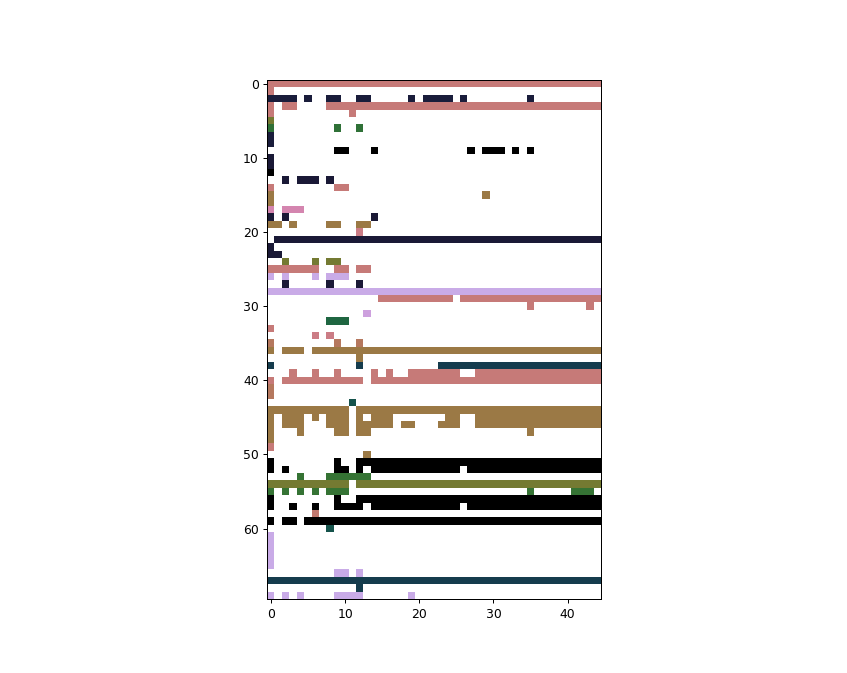

In [43]:
plt.imshow(matrix_fp_dev,interpolation='none',cmap="cubehelix_r")
plt.title("False positives")

<IPython.core.display.Javascript object>


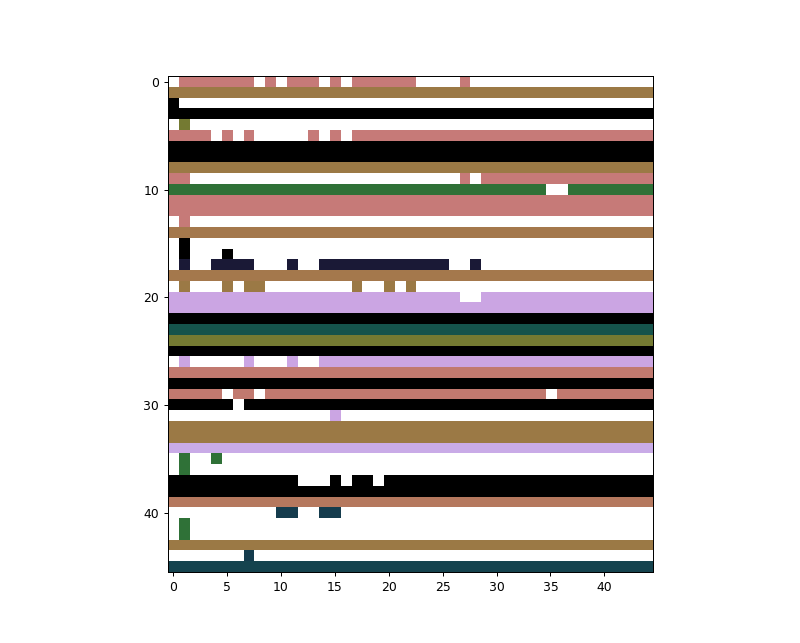

In [44]:
plt.imshow(matrix_fn_dev,interpolation='none',cmap="cubehelix_r")
plt.title("False negatives")

## Logit model

In [10]:
p_test_list = list()
r_test_list = list()
p_dev_list = list()
r_dev_list = list()
p_val_list = list()
r_val_list = list()
fscore_dev_list = list()
fscore_test_list = list()
fscore_val_list = list()

In [12]:
for n_epoch in range(400):
    disc_model = None
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="SparseLogisticRegression_fullchk4_epoch_{}".format(n_epoch),
        save_dir=args.save_dir)
    pt,rt,ft = disc_model.score(F_test, Y_test, batch_size=32,beta=0.8)
    pd,rd,fd = disc_model.score(F_dev, Y_dev, batch_size=32,beta=0.8)
#     pv,rv,fv = disc_model.score(sorted_dev_cands, Y_valid, batch_size=32,beta=0.8)
    p_test_list.append(pt) 
    r_test_list.append(rt) 
    p_dev_list.append(pd) 
    r_dev_list.append(rd) 
    fscore_dev_list.append(fd) 
    fscore_test_list.append(ft)
#     p_val_list.append(pv)
#     r_val_list.append(rv)
#     fscore_val_list.append(fv)
    print("P dev:{0:.2f}\tP test:{1:.2f}\tR dev:{2:.2f}\tRtest:{3:.2f}\t".format(pd,pt,rd,rt) )

INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk4_epoch_0/SparseLogisticRegression_fullchk4_epoch_0-0
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk4_epoch_0>
P dev:0.23	P test:0.27	R dev:0.23	Rtest:0.16	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk4_epoch_1/SparseLogisticRegression_fullchk4_epoch_1-1
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk4_epoch_1>
P dev:0.44	P test:0.64	R dev:0.25	Rtest:0.18	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk4_epoch_2/SparseLogisticRegression_fullchk4_epoch_2-2
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk4_epoch_2>
P dev:0.50	P test:0.86	R dev:0.27	Rtest:0.24	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk4_epoch_3/SparseLogisticRegression_fullchk4_epoch_3-3
[SparseLogisticRegression] Loaded model <SparseLog

In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


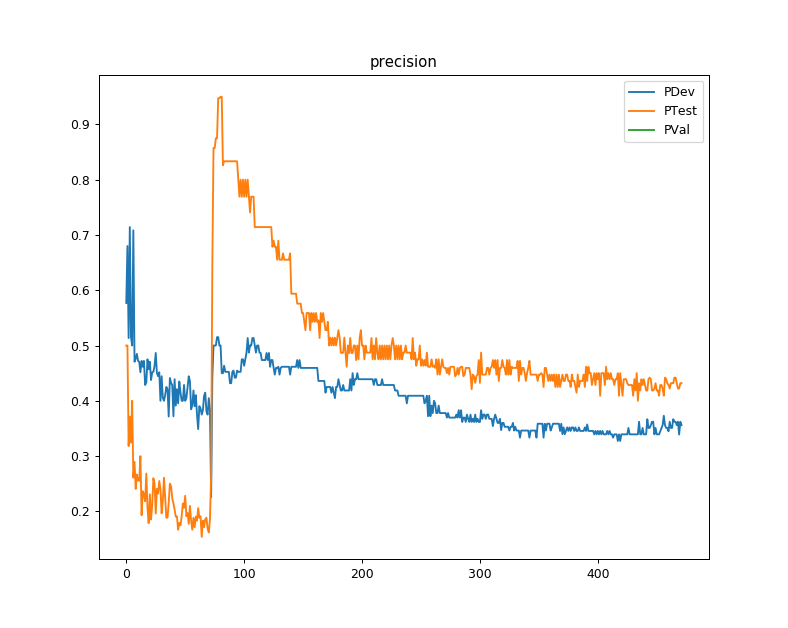

Text(0.5,1,u'precision')

In [16]:
plt.plot(p_dev_list,label = "PDev")
plt.plot(p_test_list,label = "PTest")
plt.plot(p_val_list,label = "PVal")
plt.legend()
plt.title("precision")

<IPython.core.display.Javascript object>


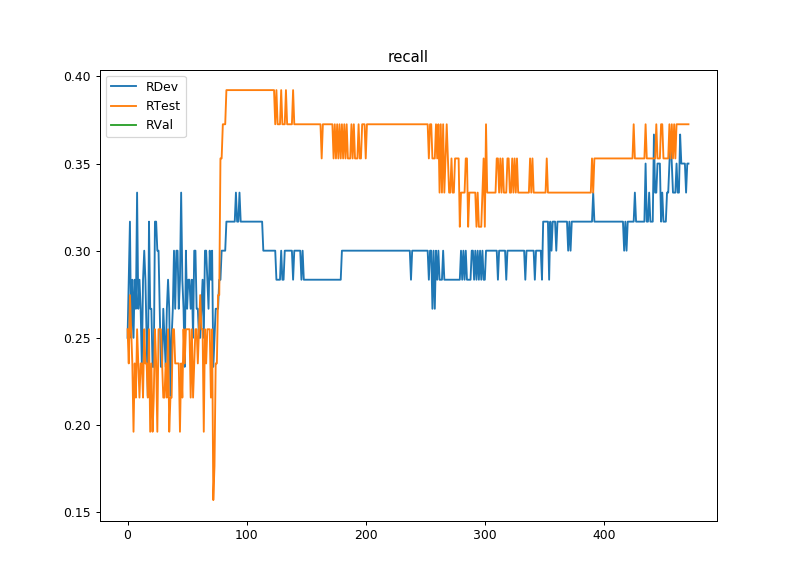

Text(0.5,1,u'recall')

In [17]:
plt.plot(r_dev_list,label = "RDev")
plt.plot(r_test_list,label = "RTest")
plt.plot(r_val_list,label = "RVal")
plt.legend()
plt.title("recall")

In [24]:
p_test_list = list()
r_test_list = list()
p_dev_list = list()
r_dev_list = list()
p_val_list = list()
r_val_list = list()
fscore_dev_list = list()
fscore_test_list = list()
fscore_val_list = list()

In [28]:
for n_epoch in range(400):
    disc_model = None
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="SparseLogisticRegression_fullchk_pr1__epoch_{}".format(n_epoch),
        save_dir=args.save_dir)
    pt,rt,ft = disc_model.score(F_test, Y_test, batch_size=32,beta=0.8)
    pd,rd,fd = disc_model.score(F_dev, Y_dev, batch_size=32,beta=0.8)
#     pv,rv,fv = disc_model.score(sorted_dev_cands, Y_valid, batch_size=32,beta=0.8)
    p_test_list.append(pt) 
    r_test_list.append(rt) 
    p_dev_list.append(pd) 
    r_dev_list.append(rd) 
    fscore_dev_list.append(fd) 
    fscore_test_list.append(ft)
#     p_val_list.append(pv)
#     r_val_list.append(rv)
#     fscore_val_list.append(fv)
    print("P dev:{0:.2f}\tP test:{1:.2f}\tR dev:{2:.2f}\tRtest:{3:.2f}\t".format(pd,pt,rd,rt) )

INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk_pr1__epoch_0/SparseLogisticRegression_fullchk_pr1__epoch_0-0
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk_pr1__epoch_0>
P dev:0.57	P test:0.94	R dev:0.27	Rtest:0.29	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk_pr1__epoch_1/SparseLogisticRegression_fullchk_pr1__epoch_1-1
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk_pr1__epoch_1>
P dev:0.68	P test:0.88	R dev:0.35	Rtest:0.29	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk_pr1__epoch_2/SparseLogisticRegression_fullchk_pr1__epoch_2-2
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_fullchk_pr1__epoch_2>
P dev:0.57	P test:0.94	R dev:0.33	Rtest:0.29	
INFO:tensorflow:Restoring parameters from checkpoints/SparseLogisticRegression_fullchk_pr1__epoch_3/SparseLogisticRegression_fullchk_pr1__epoch_3-3
[Spars

In [32]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


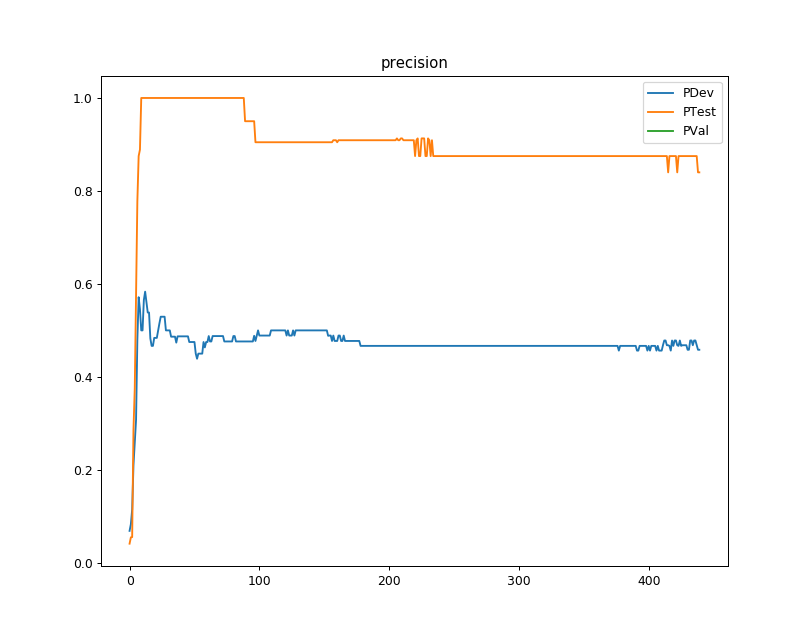

Text(0.5,1,u'precision')

In [18]:
plt.plot(p_dev_list,label = "PDev")
plt.plot(p_test_list,label = "PTest")
plt.plot(p_val_list,label = "PVal")
plt.legend()
plt.title("precision")

<IPython.core.display.Javascript object>


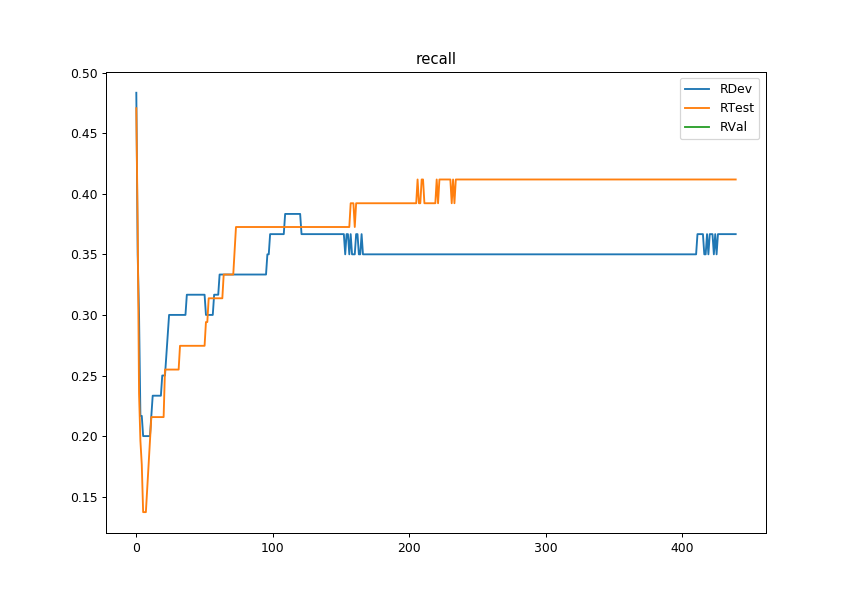

Text(0.5,1,u'recall')

In [19]:
plt.plot(r_dev_list,label = "RDev")
plt.plot(r_test_list,label = "RTest")
plt.plot(r_val_list,label = "RVal")
plt.legend()
plt.title("recall")

In [20]:
f1_list_dev = list()
f1_list_test = list()

for p,r in zip(p_dev_list,r_dev_list):
    f1_list_dev.append(2*p*r/(p+r))
for p,r in zip(p_test_list,r_test_list):
    f1_list_test.append(2*p*r/(p+r))


<IPython.core.display.Javascript object>


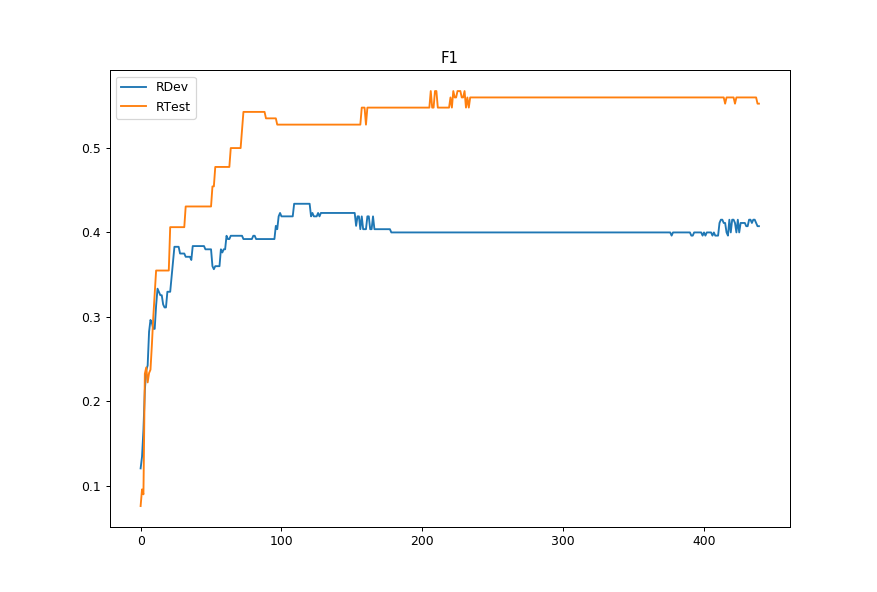

Text(0.5,1,u'F1')

In [21]:
plt.plot(f1_list_dev,label = "RDev")
plt.plot(f1_list_test,label = "RTest")
plt.legend()
plt.title("F1")

In [22]:
lst_loss = list()
with open("../Notes/training_logit.txt","r") as f:
    for line in f:
        if "loss" in line:
            lss = float(line.split("loss=")[-1].split()[0].strip())
            lst_loss.append(lss)

<IPython.core.display.Javascript object>


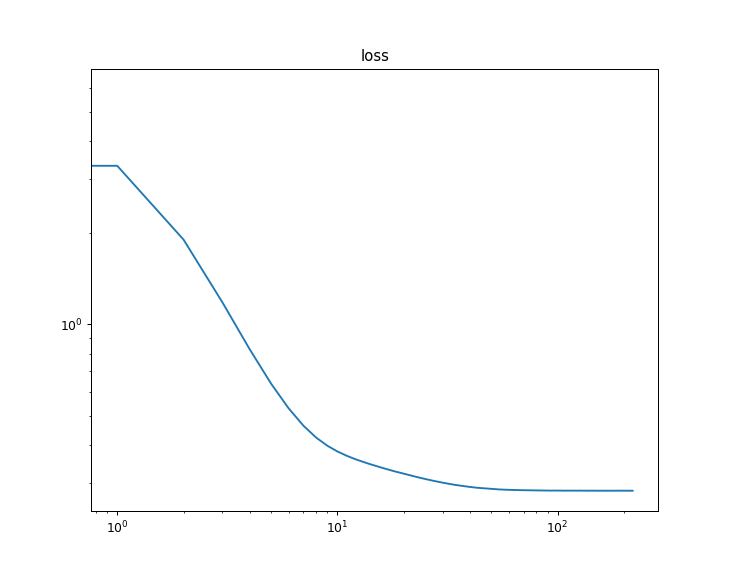

Text(0.5,1,u'loss')

In [26]:
plt.plot(lst_loss)
plt.yscale("log")
plt.xscale("log")
plt.title("loss (log scales)")

### Appendix: plot with clustered rows

In [187]:
list_dico_misclassif = list()
dic_docs = dict()
list_dico_misclassif_dev = list()
dic_docs_dev = dict()
for n_epoch in range(45):
    disc_model = None
    disc_model = config['disc-model-class'](
        cardinality=C.cardinality,
        **config['disc-init-params'])
    disc_model.load(model_name="reRNN_fullchk6_epoch_{}".format(n_epoch),
        save_dir=args.save_dir)
    _, fp, _, fn =disc_model.error_analysis(X_test=X_test,Y_test=Y_test,display=False,session=sess)
    list_dico_misclassif.append(dict(epoch = n_epoch,false_positives = [x.id for x in fp],false_negatives = [x.id for x in fn]))
    for x in fp.union(fn):
        dic_docs[x.id] = x.chem1.sentence.document_id
    _, fpd, _, fnd =disc_model.error_analysis(X_test=X_dev,Y_test=Y_dev,display=False,session=sess)
    list_dico_misclassif_dev.append(dict(epoch = n_epoch,false_positives = [x.id for x in fp],false_negatives = [x.id for x in fn]))
    for x in fpd.union(fnd):
        dic_docs_dev[x.id] = x.chem1.sentence.document_id

INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_0/reRNN_fullchk6_epoch_0-0
[reRNN] Loaded model <reRNN_fullchk6_epoch_0>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_1/reRNN_fullchk6_epoch_1-1
[reRNN] Loaded model <reRNN_fullchk6_epoch_1>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_2/reRNN_fullchk6_epoch_2-2
[reRNN] Loaded model <reRNN_fullchk6_epoch_2>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_3/reRNN_fullchk6_epoch_3-3
[reRNN] Loaded model <reRNN_fullchk6_epoch_3>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_4/reRNN_fullchk6_epoch_4-4
[reRNN] Loaded model <reRNN_fullchk6_epoch_4>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_5/reRNN_fullchk6_epoch_5-5
[reRNN] Loaded model <reRNN_fullchk6_epoch_5>
INFO:tensorflow:Restoring parameters from checkpoints/reRNN_fullchk6_epoch_6/reRNN_fullchk6_epoch_6-6
[reRNN] Lo

In [188]:

total_docs = set(dic_docs.values())
colormap = dict([(x,0.25+0.75*y/len(total_docs)) for y,x in enumerate(total_docs)])

total_docs_dev = set(dic_docs_dev.values())
colormap_dev = dict([(x,0.25+0.75*y/len(total_docs_dev)) for y,x in enumerate(total_docs_dev)])

In [189]:
len(colormap),len(colormap_dev)

(17, 17)

In [190]:
all_false_negs= list(set([x for d in list_dico_misclassif for x in d["false_negatives"]  ]))
all_false_pos= list(set([x for d in list_dico_misclassif for x in d["false_positives"]  ]))
dic_false_pos = dict([(x,y) for y,x in enumerate(all_false_pos)])
dic_false_negs = dict([(x,y) for y,x in enumerate(all_false_negs)])

In [191]:
len(all_false_negs),len(all_false_pos)

(41, 48)

In [192]:
pers_matrix_false_negs = np.zeros((len(all_false_negs),len(list_dico_misclassif)))
pers_matrix_false_pos = np.zeros((len(all_false_pos),len(list_dico_misclassif)))

In [193]:
for d in list_dico_misclassif:
    for i_fp in d["false_positives"]:
        pers_matrix_false_pos[dic_false_pos[i_fp],d["epoch"]] = colormap[dic_docs[i_fp]]
    for i_fn in d["false_negatives"]:
        pers_matrix_false_negs[dic_false_negs[i_fn],d["epoch"]] = colormap[dic_docs[i_fn]]

In [194]:
pers_matrix_false_negs

array([[ 0.77941176,  0.77941176,  0.77941176, ...,  0.77941176,
         0.77941176,  0.77941176],
       [ 0.77941176,  0.77941176,  0.77941176, ...,  0.77941176,
         0.77941176,  0.77941176],
       [ 0.        ,  0.38235294,  0.38235294, ...,  0.38235294,
         0.38235294,  0.38235294],
       ..., 
       [ 0.        ,  0.        ,  0.82352941, ...,  0.82352941,
         0.82352941,  0.82352941],
       [ 0.        ,  0.        ,  0.64705882, ...,  0.64705882,
         0.64705882,  0.64705882],
       [ 0.        ,  0.        ,  0.64705882, ...,  0.64705882,
         0.64705882,  0.64705882]])

In [195]:
pers_matrix_false_pos

array([[ 0.        ,  0.38235294,  0.        , ...,  0.38235294,
         0.38235294,  0.38235294],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.33823529,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.29411765,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.42647059,  0.42647059, ...,  0.42647059,
         0.42647059,  0.42647059]])

In [196]:
pers_matrix_false_negs[2,:]

array([ 0.        ,  0.38235294,  0.38235294,  0.38235294,  0.        ,
        0.38235294,  0.        ,  0.38235294,  0.38235294,  0.        ,
        0.        ,  0.38235294,  0.38235294,  0.38235294,  0.38235294,
        0.38235294,  0.38235294,  0.38235294,  0.38235294,  0.38235294,
        0.38235294,  0.38235294,  0.38235294,  0.38235294,  0.38235294,
        0.        ,  0.        ,  0.38235294,  0.38235294,  0.38235294,
        0.38235294,  0.38235294,  0.38235294,  0.38235294,  0.38235294,
        0.38235294,  0.38235294,  0.38235294,  0.38235294,  0.38235294,
        0.38235294,  0.38235294,  0.38235294,  0.38235294,  0.38235294])

In [124]:
index_permut_fn = np.array(sorted(list(range(pers_matrix_false_negs.shape[0])),key = lambda i: (np.sum(pers_matrix_false_negs[i,:]),[j for j in range(pers_matrix_false_negs.shape[1]) if pers_matrix_false_negs[i,j]==1][-1])))
index_permut_fp = np.array(sorted(list(range(pers_matrix_false_pos.shape[0])),key = lambda i: (np.sum(pers_matrix_false_pos[i,:]),[j for j in range(pers_matrix_false_pos.shape[1]) if pers_matrix_false_pos[i,j]==1][-1])))

In [197]:
pers_matrix_false_negs.shape

(41, 45)

In [198]:
metri = 'correlation'
#metri  = 'seuclidean'
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
Y=pdist(pers_matrix_false_negs, metri)
Z=linkage(Y, 'single')
order_fn = np.array(dendrogram(Z, color_threshold=0,no_plot=True)["leaves"])
Y=pdist(pers_matrix_false_pos, metri)
Z=linkage(Y, 'single')
order_fp = np.array(dendrogram(Z, color_threshold=0,no_plot=True)["leaves"])